# Импорт библиотек и данных

In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import re

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set_style('darkgrid')

from IPython.display import display, display_html, HTML

root_folder = '../'
sys.path.append(root_folder)
# from src.data import make_dataset
from src import utils
from src.features import build_features
from src.visualization import visualize
from src.features import feature_stats

pd.options.mode.copy_on_write = True

preprocessed_data = Path(
    root_folder, 'data', 'interim', '2.0_preprocessed.csv'
)

In [2]:
df = pd.read_csv(
    preprocessed_data,
    index_col=0
)
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
Index: 330799 entries, 0 to 374305
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   status                      330799 non-null  object 
 1   baths                       330799 non-null  float64
 2   fireplace                   330799 non-null  bool   
 3   beds                        330799 non-null  float64
 4   state                       330799 non-null  object 
 5   stories                     330799 non-null  float64
 6   target                      330799 non-null  int64  
 7   private_pool                330799 non-null  bool   
 8   mls                         330799 non-null  bool   
 9   property_type               330799 non-null  object 
 10  parking_type                330799 non-null  object 
 11  parking_count               330799 non-null  float64
 12  central_heating             330799 non-null  bool   
 13  heating_type       

,status,baths,fireplace,beds,state,stories,target,private_pool,mls,property_type,...,cooling_type,log_target,log_sqft,log_lotsize,updated_years,school_count,min_log_school_distance,median_log_school_distance,max_school_rating,median_school_rating
0,active/sale,4.0,True,4.0,NC,1.0,418000,False,True,single,...,central,5.621176,3.462548,3.886885,3.0,8,0.431525,0.579898,7.0,5.0
1,active/sale,3.0,False,3.0,WA,2.0,310000,False,True,single,...,central,5.491362,3.289589,3.765594,3.0,3,0.004751,0.120903,7.0,5.0
2,active/sale,2.0,True,3.0,CA,1.0,2895000,True,True,single,...,central,6.461649,3.477266,3.935860,55.0,3,0.075912,0.314078,8.0,8.0
3,active/sale,6.0,True,5.0,TX,3.0,2395000,False,True,single,...,central,6.379306,3.810098,3.914925,16.0,4,-0.995679,-0.031050,10.0,9.0
5,active/sale,2.0,False,2.0,other,2.0,209000,False,True,town,...,central,5.320146,2.953276,2.833147,102.0,1,-0.995679,-0.031050,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374300,active/sale,3.0,False,2.0,other,3.0,799000,False,True,condo,...,central,5.902547,3.151676,3.875119,12.0,2,-0.995679,-0.600326,3.0,3.0
374301,active/sale,6.0,False,5.0,FL,1.0,1249000,True,True,single,...,central,6.096562,3.604010,3.929470,32.0,2,0.041787,1.220134,10.0,7.5
374302,active/sale,3.0,False,3.0,other,4.0,674999,False,True,condo,...,central,5.829303,3.301247,3.929470,98.0,3,-0.396856,0.152594,7.0,5.0
374303,active/sale,3.0,False,3.0,NY,2.0,528000,False,False,single,...,central,5.722634,3.061829,3.204391,72.0,2,-0.317855,-0.217527,5.0,4.5


## Отбор признаков

Продолжим проектирование и отбор признаков.

Воспользуемся one-hot encoding для кодирования номинальных категориальных признаков

In [3]:
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330799 entries, 0 to 374305
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            330799 non-null  float64
 1   fireplace                        330799 non-null  bool   
 2   beds                             330799 non-null  float64
 3   stories                          330799 non-null  float64
 4   target                           330799 non-null  int64  
 5   private_pool                     330799 non-null  bool   
 6   mls                              330799 non-null  bool   
 7   parking_count                    330799 non-null  float64
 8   central_heating                  330799 non-null  bool   
 9   central_cooling                  330799 non-null  bool   
 10  log_target                       330799 non-null  float64
 11  log_sqft                         330799 non-null  float64
 12  log_lot

При проведении тестов на сравнение выборок важно учитывать, что ранее с помощью теста Д'Агостино было получено, что числовые признаки НЕ распределены нормально.
В связи с чем лучше использовать непараметрические тесты.

Проверим статистическую значимость разницы в стоимости объявления в зависимости значения булевых признаков.
Для этого применим **знаковый ранговый тест Уилкоксона**, базовая гипотеза которого в том, что обе сравниваемые выборки происходят из одного распределения. Если p-value меньше уровня значимости, нулевая гипотеза отвергается и мы говорим о том, что есть статистически значимая разница между выборками.

In [4]:
bool_cols = df.columns[df.dtypes == 'bool']
print(bool_cols)

importance = feature_stats.test_wilcoxon(
    df,
    bool_features=bool_cols
)
importance = pd.Series(importance)
print(
    f'Статистически незначимые различия в признаках:',
    list(importance[~importance].index)
)

Index(['fireplace', 'private_pool', 'mls', 'central_heating',
       'central_cooling', 'status_active/sale', 'status_contract/new',
       'status_foreclosure/pending', 'state_CA', 'state_FL', 'state_NC',
       'state_NY', 'state_OH', 'state_TN', 'state_TX', 'state_WA',
       'state_other', 'property_type_condo', 'property_type_land/mobile',
       'property_type_multi', 'property_type_ranch/traditional',
       'property_type_single', 'property_type_styled', 'property_type_town',
       'parking_type_garage', 'parking_type_other', 'parking_type_street',
       'heating_type_central', 'heating_type_electric',
       'heating_type_gas/pump', 'heating_type_other', 'cooling_type_central',
       'cooling_type_other', 'cooling_type_refrigeration/fan'],
      dtype='object')
Рассматриваемый признак: fireplace
Размер выборок: 96592
p-value=0.00e+00 <= alpha=1.00e-02
ЕСТЬ статистически значимое различие по log_target

Рассматриваемый признак: private_pool
Размер выборок: 42050
p-value=0.00

Важно отметить, что выборки из некоторых признаков относительно малы:

In [5]:
small_groups = ['property_type_styled', 'status_contract/new']

Избавимся от этих признаков:

In [6]:
df = df.drop(['mls', 'heating_type_other'], axis=1)
print(f'Размер датасета: {df.shape}')

Размер датасета: (330799, 46)


Теперь посмотрим на корреляцию Спирмена, применимого для ненормального распределения и при наличии нелинейной связи.

Оценим сначала мультиколлинеарные признаки. Для наглядности, оставим только те строки/столбы, которые содержат в себе коэффициенты по модулю больше 0.7

Для сравнения разницы, построим также корреляцию Пирсона

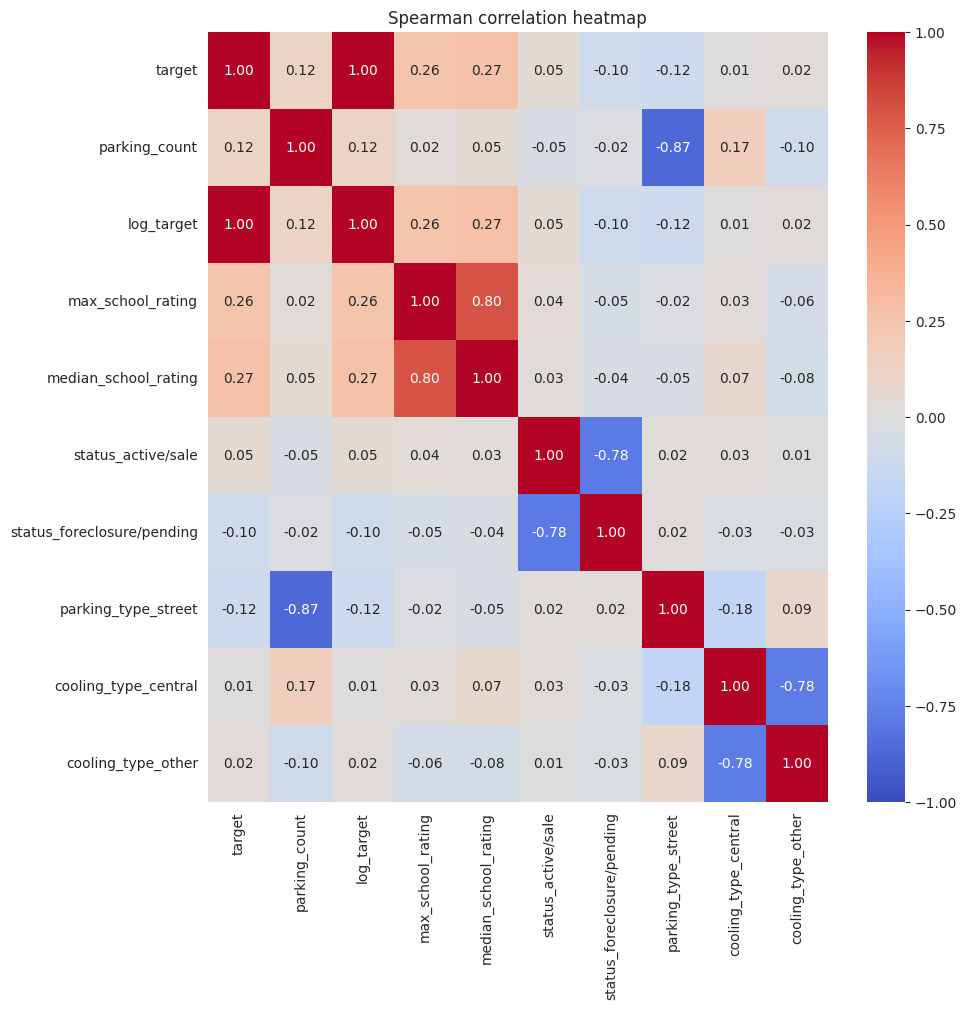

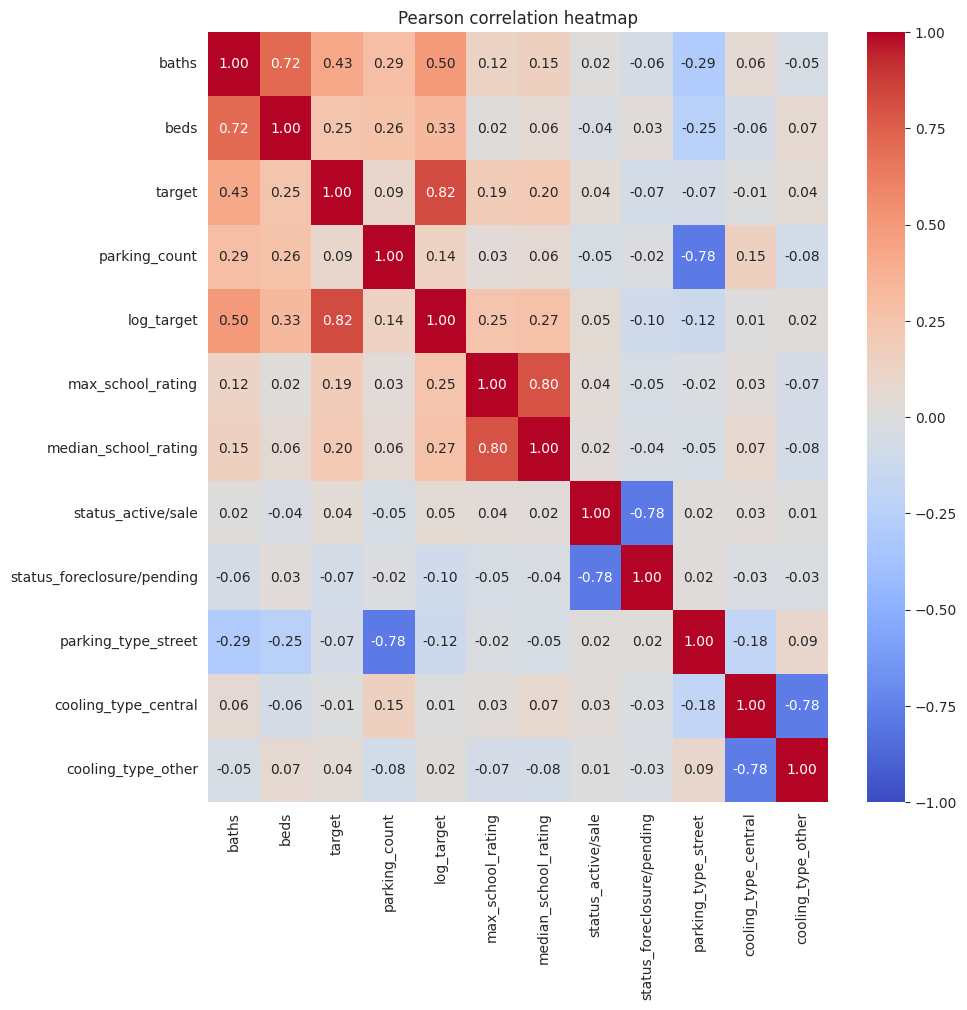

In [7]:
corr_df = feature_stats.get_correlated_df(
    df,
    threshold=0.7,
    method='spearman'
)

fig = visualize.plot_heatmap(
    corr_df,
    title='Spearman correlation heatmap',
    figsize=(10,10)
);

pearson_corr_df = feature_stats.get_correlated_df(
    df,
    threshold=0.7,
    method='pearson'
)

fig = visualize.plot_heatmap(
    pearson_corr_df,
    title='Pearson correlation heatmap',
    figsize=(10,10)
);

Исключим следующие признаки (и старый таргет):

In [8]:
multicollinear_features = [
    'target',
    'parking_type_street',
    'max_school_rating',
    'cooling_type_central',
    'status_active/sale'
]
df = df.drop(multicollinear_features, axis=1)
print(f'Размер датасета: {df.shape}')

Размер датасета: (330799, 41)


Оценим теперь корреляцию с таргетом и выведем лучшие (поставив порог в 0.1).

Также Сопоставим с корреляцией Кендала:

,log_target
log_sqft,0.486732
baths,0.454720
beds,0.276844
median_school_rating,0.268723
stories,0.240869
state_CA,0.220813
property_type_land/mobile,-0.199556
fireplace,0.162347
state_NY,0.159568
updated_years,-0.158205


Количество лучших признаков: 15


,log_target
baths,0.361637
log_sqft,0.347317
beds,0.212379
median_school_rating,0.191529
stories,0.190924
state_CA,0.180409
property_type_land/mobile,-0.163042
fireplace,0.132641
state_NY,0.130371
state_OH,-0.128328


Количество лучших признаков: 12
Признаки включены в Спирмена: True


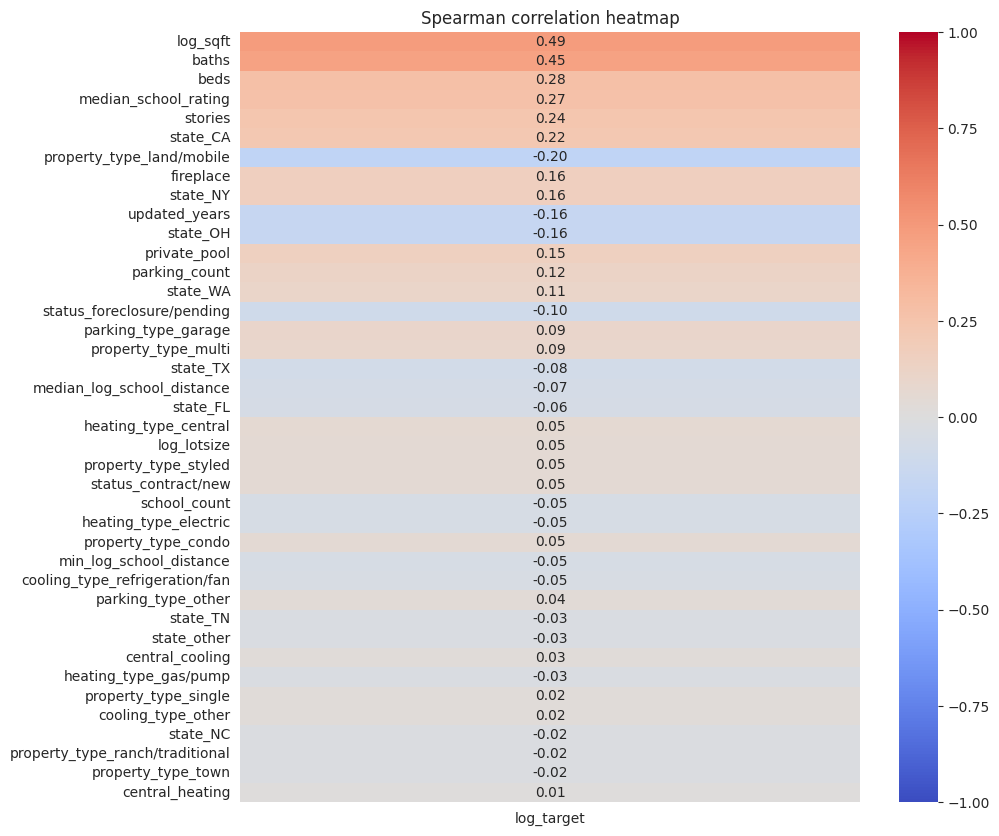

In [9]:
target_corr_df = feature_stats.get_correlated_df(
    df,
    threshold=0.0,
    method='spearman'
)[['log_target']]

target_corr_df = target_corr_df.sort_values(
    by='log_target', 
    key=lambda x: abs(x), 
    ascending=False
)
fig = visualize.plot_heatmap(
    target_corr_df.iloc[1:],
    title='Spearman correlation heatmap',
    figsize=(10,10)
);

best_correlated = target_corr_df[np.abs(target_corr_df)>=0.1][1:].dropna()
display(best_correlated)
print(f'Количество лучших признаков: {len(best_correlated)}')
best_correlated = set(best_correlated.index)


target_corr_df_kendal = feature_stats.get_correlated_df(
    df,
    threshold=0.0,
    method='kendall'
)[['log_target']]

target_corr_df_kendal = target_corr_df_kendal.sort_values(
    by='log_target', 
    key=lambda x: abs(x), 
    ascending=False
)

best_correlated_kendal = target_corr_df_kendal[
    np.abs(target_corr_df_kendal)>=0.1
][1:].dropna()
display(best_correlated_kendal)
print(f'Количество лучших признаков: {len(best_correlated_kendal)}')
best_correlated_kendal = set(best_correlated_kendal.index)

print('Признаки включены в Спирмена:',
    best_correlated_kendal.issubset(best_correlated)
)

Сопоставим с результатом работы `SelectKBest` на `f_regression`

In [10]:
X = df.drop('log_target', axis=1)
y = df['log_target']

selector = SelectKBest(f_regression, k=15)
selector.fit(X, y)
 
features_kbest = set(selector.get_feature_names_out())
features_kbest = set(features_kbest)

print(
    'Непопавшие в best_correlated:', 
    features_kbest.difference(best_correlated)
)

print(
    'Непопавшие в features_kbest:', 
    best_correlated.difference(features_kbest)
)

Непопавшие в best_correlated: {'parking_type_garage'}
Непопавшие в features_kbest: {'state_WA'}


Видим, что результаты почти не отличаются.
В разделе моделирования будем отбирать признаки методами из sklearn

# Export

Выделим однократно обучающую и тестовую выборки, не удаляя пока никакие признаки.

In [11]:
random_state = 42

train, test = train_test_split(
    df,
    test_size=0.2,
    random_state=random_state,
)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

dataframes = (('train', train), ('test', test))

for name, sub_df in dataframes:
    print(f'Dataframe {name}')
    sub_df.info()
    
    processed_data_path = Path(
        root_folder, 'data', 'processed', f'2.0_{name}.csv'
    )
    df.to_csv(processed_data_path)
    print()

Dataframe train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264639 entries, 0 to 264638
Data columns (total 41 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            264639 non-null  float64
 1   fireplace                        264639 non-null  bool   
 2   beds                             264639 non-null  float64
 3   stories                          264639 non-null  float64
 4   private_pool                     264639 non-null  bool   
 5   parking_count                    264639 non-null  float64
 6   central_heating                  264639 non-null  bool   
 7   central_cooling                  264639 non-null  bool   
 8   log_target                       264639 non-null  float64
 9   log_sqft                         264639 non-null  float64
 10  log_lotsize                      264639 non-null  float64
 11  updated_years                    264639 non-null 

# Выводы

Итого, получили тестовый (20%) и обучающий (80%) датасеты. И сохранили в "data/processed/2.0_test.csv" и  "data/processed/2.0_train.csv"

Функция подготовки финальных датасетов представлена в `src.data.make_datasets`

Будем использовать один тестовый датасет для финальной оценки моделей